# Programma per importare dati da QUADERA #

_Autore: Carlo Roncolato_

_Data: 03/12/2024_

## Definizioni ##

In [3]:
import os
import re
import tkinter as tk
from tkinter import filedialog
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm



formato_data = "%d/%m/%Y %H:%M:%S"  # Specifica il formato della stringa


In [4]:
def leggi_intestazione(file_path):
    # Dizionario per memorizzare i dati estratti
    intestazione = {}
    
    # Apri il file in modalità lettura
    with open(file_path, 'r') as file:
        # Leggi il contenuto del file riga per riga
        for line in file:
            # Rimuovi spazi bianchi iniziali e finali dalla riga
            line = line.strip()

            # Cerca e memorizza i dati con le espressioni regolari
            if line.startswith("Sourcefile"):
                intestazione["Sourcefile"] = line.split("\t")[1]  # Estrae il nome del file
                data_str = intestazione["Sourcefile"].split(" ")[1]
                data_pm = datetime.strptime(data_str, "%H%M%S").hour > 12
            elif line.startswith("Exporttime"):
                intestazione["Exporttime"] = datetime.strptime(line.split("\t")[1], formato_data) # Estrae il tempo di esportazione
            elif line.startswith("Start Time"):
                intestazione["Start Time"] = datetime.strptime(line.split("\t")[1], formato_data) # Estrae l'orario di inizio
            elif line.startswith("End Time"):
                intestazione["End Time"] = datetime.strptime(line.split("\t")[1], formato_data)  # Estrae l'orario di fine
                break
        
        print("Nome del file: ", intestazione["Sourcefile"])
        print("Start Time:", intestazione["Start Time"])
        print("End Time:", intestazione["End Time"])

    return intestazione

In [5]:
def seleziona_file():
    # Crea una finestra principale nascosta per il file dialog
    root = tk.Tk()
    root.withdraw()  # Nasconde la finestra principale
    # Apri il file explorer per selezionare un file
    file_path = filedialog.askopenfilename(
        title="Seleziona il file",
        filetypes=[("Text files", "*.asc"), ("All files", "*.*")]
    )
    return file_path

In [6]:
#estratti = [
#    (
#        (
#            blocco["Start Time"] - intestazione["Start Time"]).total_seconds(),
#            [blocco["Mass/IonCurrent"][i][1] for i in indici]
#        ) 
#    for blocco in blocchi]

def read_bargraph_cycles(file_path):
    
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Time/IonCurrent": []}  # Iniziamo un nuovo blocco
        indice = 0 # inizializza l'indice che conta i blocchi
        lista_correnti = [] # Inizializza la lista delle correnti

        for line in tqdm(file):
            line = line.strip()
            
            if line.startswith("Start Time"):
                lettura = datetime.strptime(line.split("\t")[1], formato_data)
                
                if indice == 0:
                    tempo_inizio = lettura

                elif indice > 1 and lista_correnti: # Salta il primo blocco e controlla che la lista delle correnti sia vuota
                    
                    tempo_lettura = (lettura - tempo_inizio).total_seconds()  # Calcola il tempo trascorso dalla prima lettura

                    # Controllo che il blocco sia completo
                    if len(lista_correnti) == numero_letture:
                        blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])
                        lista_correnti = []  # Resetta la lista delle correnti
            
                indice += 1 # Incrementa l'indice del blocco

            if line.startswith("First Mass"):
                prima_massa = int(float(line.split("\t")[1].replace(',', '.')))

            if line.startswith("Scan Width"):
                numero_letture = int(float(line.split("\t")[1].replace(',', '.')))
            
            else:
                # Rileva le righe di dati "Mass [amu] <numero> Ion Current [A] <numero>"
                match = re.match(r"(\d+,\d+)\t([+-]?\d+\,\d+e[+-]?\d+)", line)
                if match:
                    massa = float(match.group(1).replace(',', '.'))  # Converte il mass in float
                    corrente = float(match.group(2).replace(',', '.'))  # Ion Current è già un numero float
                    lista_correnti.append(corrente)

        blocco["Mass Indexes"] = [prima_massa + i for i in range(numero_letture)]
            
    return blocco

In [7]:
def read_mainElements_cycles(file_path):
   
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Time/IonCurrent": []}  # Iniziamo un nuovo blocco

        for line in tqdm(file):
            line = line.rstrip()
            
            if line.startswith("\t\t"):
                blocco["Mass Indexes"] = [int(x) for x in line.strip().split("\t\t\t") if re.match(r"0?[1-9]", x)]

            elif line.startswith("Time"):
                # Iniziamo a leggere le coppie di valori (Mass, Ion Current)
                continue  # La riga di intestazione non contiene dati
             
            else:
                # Rileva le righe di dati
                pattern = r"(0[1-9]|1[0-2])/(0?[1-9]|[12][0-9]|3[01])/\d{4}"
                match = re.match(pattern, line)
                if match:
                    lettura = line.replace(',', '.')
                    serie_letture = [elemento.strip() for elemento in lettura.split("\t")]
                
                    if len(serie_letture) >= (len(blocco["Mass Indexes"]) - 1) * 3 + 2:
                        tempo_lettura = (float(serie_letture[1]) + float(serie_letture[-2]))/2
                        lista_correnti = []
                    
                        for idx, dato in enumerate(blocco["Mass Indexes"]):
                            corrente = serie_letture[idx*3 + 2]
                            lista_correnti.append(float(corrente))

                        blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])

    return blocco

In [8]:
def read_analog_cycles(file_path):
   
    i = 0         # inizializza l'indice del blocco
    
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Time/IonCurrent": [], "Mass Indexes": []}  # Iniziamo un nuovo blocco
        
        task_name_encountered = 0
        
        tempo_inizio = 0
        tempo_lettura = 0
        
        lista_masse = []
        lista_correnti = []
        
        for line in tqdm(file, desc="Lettura del file"):
            line = line.strip()
            
            if line.startswith("Task Name"):
                task_name_encountered += 1
                if task_name_encountered == 1:
                    # print("Skipping first task name")
                    continue  # La prima volta continua il ciclo
                else:
                    # Se c'è già un blocco, lo aggiungiamo alla lista
                    # print("Adding block", i)                  
                    blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])
                    blocco["Mass Indexes"].append([tempo_lettura, lista_masse])

                # incrementa indice del blocco e reset delle variabili
                i += 1 
                lista_correnti = []
                lista_masse = []
                # print("blocco", i)
                
            elif line.startswith("Start Time"):
                if tempo_inizio == 0:
                    tempo_inizio = datetime.strptime(line.split("\t")[1], formato_data)
                
                lettura = datetime.strptime(line.split("\t")[1], formato_data)
                tempo_lettura = (lettura - tempo_inizio).total_seconds()
                # print(i, lettura, tempo_inizio, tempo_lettura)
                
            else:
                # Rileva le righe di dati "Mass [amu] <numero> Ion Current [A] <numero>"
                match = re.match(r"(\d+.\d+)\t([+-]?\d+\.\d+e[+-]?\d+)", line.replace(',', '.'))
                if match:
                    massa = float(match.group(1).replace(',', '.'))
                    corrente_ionica = float(match.group(2).replace(',', '.'))  # Ion Current è già un numero float
                    lista_masse.append(massa)
                    lista_correnti.append(corrente_ionica)
                    
    # Aggiungiamo l'ultimo blocco
    if blocco: 
        # print("Adding block", i)                  
        blocco["Time/IonCurrent"].append([tempo_lettura, lista_correnti])
        blocco["Mass Indexes"].append([tempo_lettura, lista_masse])    

    # Pulizia dei blocchi incompleti  
    lunghezza_blocco = [len(row[1]) for row in blocco["Mass Indexes"]]  
    posizioni_incomplete = [i for i, value in enumerate(lunghezza_blocco) if value != max(lunghezza_blocco)]
    blocco["Time/IonCurrent"] = [row for i, row in enumerate(blocco["Time/IonCurrent"]) if i not in posizioni_incomplete]
    blocco["Mass Indexes"] = [row for i, row in enumerate(blocco["Mass Indexes"]) if i not in posizioni_incomplete]
    blocco["Mass Indexes"] = blocco["Mass Indexes"][0][1]

    return blocco

## Importazione Dati ##

### Selezione del file di input ###

In [9]:
# Esegui il programma con la selezione del file tramite il selettore
# file_path = seleziona_file()
file_path = "./data/20250324 164929 SEM Bargraph Cycles.asc"

In [11]:

if os.path.exists(file_path):
    intestazione = leggi_intestazione(file_path)

    if "Scan_main_elements" in intestazione["Sourcefile"]:
        print("Tipo File: Scan_Main_Elements")
        dati = read_mainElements_cycles(file_path)

    elif "Bargraph Cycles" in intestazione["Sourcefile"]:
        print("Tipo File: Bargraph Cycles")
        dati = read_bargraph_cycles(file_path)
        
    elif "Scan_analog_mod" in intestazione["Sourcefile"]:
        print("Tipo File: Analog Cycles")
        dati = read_analog_cycles(file_path)
        
    else:
        print("Formato non risconosciuto")

    if dati:
            # Stampa i dati estratti
            print("\nNumero di Blocchi Dati: ",len(dati["Time/IonCurrent"]))            
            durata = intestazione["End Time"] - intestazione["Start Time"]
            print("Durata:", durata.total_seconds())
        
else:
    print("Nessun file selezionato.")

Nome del file:  20250324 164929 SEM Bargraph Cycles.qmp
Start Time: 2025-03-24 16:49:53
End Time: 2025-03-24 22:58:53
Tipo File: Bargraph Cycles


0it [00:00, ?it/s]

125899it [00:00, 333457.32it/s]


Numero di Blocchi Dati:  2170
Durata: 22140.0


### Secondo file di input da unire ###

Aggiunge la serie di dati selezionata a quella appena importata. Poi riferisce tutti i tempi in funzione della prima serie.

In [14]:
# Esegui il programma con la selezione del file tramite il selettore
file_path_bis = "./data/20250325 114404 SEM Bargraph Cycles.asc"

In [15]:
if os.path.exists(file_path):
    intestazione_bis = leggi_intestazione(file_path_bis)

    if "Scan_main_elements" in intestazione_bis["Sourcefile"]:
        print("Tipo File: Scan_Main_Elements")
        dati_bis = read_mainElements_cycles(file_path_bis)

    elif "Bargraph Cycles" in intestazione_bis["Sourcefile"]:
        print("Tipo File: Bargraph Cycles")
        dati_bis = read_bargraph_cycles(file_path_bis)
        
    elif "Scan_analog_mod" in intestazione_bis["Sourcefile"]:
        print("Tipo File: Analog Cycles")
        dati_bis = read_analog_cycles(file_path_bis)
        
    else:
        print("Formato non risconosciuto")

    if dati_bis:
            # Stampa i dati estratti
            print("\nNumero di Blocchi Dati: ",len(dati_bis["Time/IonCurrent"]))            
            durata_bis = intestazione_bis["End Time"] - intestazione_bis["Start Time"]
            print("Durata:", durata.total_seconds())
        
else:
    print("Nessun file selezionato.")

Nome del file:  20250325 114404 SEM Bargraph Cycles.qmp
Start Time: 2025-03-25 11:44:10
End Time: 2025-03-26 01:03:35
Tipo File: Bargraph Cycles


538099it [00:01, 434382.94it/s]


Numero di Blocchi Dati:  9277
Durata: 22140.0


In [16]:
delta = (intestazione_bis["Start Time"] - intestazione["Start Time"]).total_seconds()
for punto in dati_bis["Time/IonCurrent"]:
    punto[0] = punto[0] + delta
dati["Time/IonCurrent"] = dati["Time/IonCurrent"] + dati_bis["Time/IonCurrent"]

## Visualizzazione ##

In [17]:
colori = ("b", "g", "r", "c", "k", "y", "m")
mostra_masse = [2, 18, 28, 32, 40, 44, 45]

indici = {num: [i for i, x in enumerate(dati["Mass Indexes"]) if x == num] for num in mostra_masse}
print(indici)

{2: [2], 18: [18], 28: [28], 32: [32], 40: [40], 44: [44], 45: [45]}


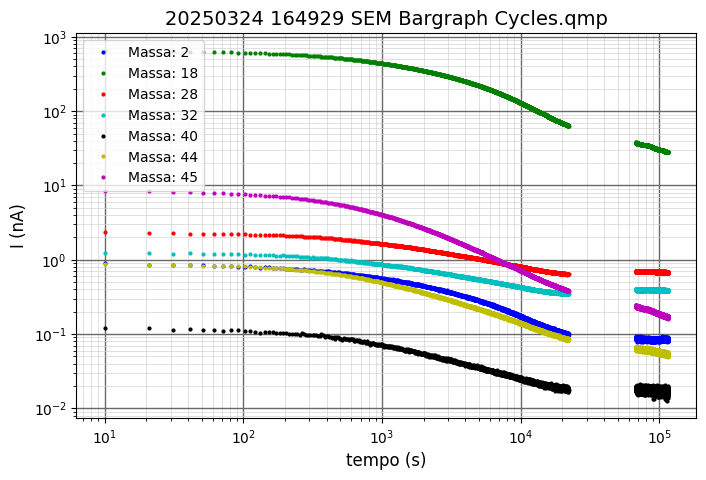

In [18]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
for idx, massa in enumerate(indici):
    pos = indici[massa][0]
    x = [punto[0] for punto in dati["Time/IonCurrent"]]
    y = [punto[1][pos]*1e9 for punto in dati["Time/IonCurrent"]]

    # plt.loglog o plot.semilogy
    plt.loglog(
                x, y,
                marker="o", 
                markersize=2,
                linestyle='',
                color=colori[idx],
                label='Massa: '+ f"{massa}"
    )
    
# Personalizzazione del grafico
plt.title(intestazione["Sourcefile"], fontsize=14)
plt.xlabel('tempo (s)', fontsize=12)
plt.ylabel('I (nA)', fontsize=12)
#plt.grid(True, which="both", linestyle='-', alpha=0.6)
plt.grid(which="major", color="dimgray", linewidth=1.0)
plt.grid(which="minor", color="lightgray", linewidth=0.5)
plt.legend(fontsize=10)

# Mostra il grafico
plt.show()

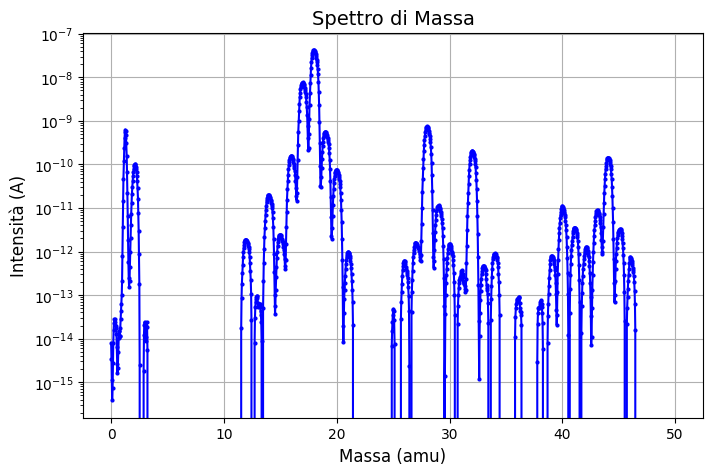

In [18]:
t = [punto[0] for punto in dati["Time/IonCurrent"]]
target = 1000  # esempio di valore target
posizione_piu_vicina = min(range(len(t)), key=lambda i: abs(t[i] - target))
spettro_y = dati["Time/IonCurrent"][posizione_piu_vicina][1]
spettro_x = dati["Mass Indexes"]
plt.figure(figsize=(8, 5))
plt.semilogy(spettro_x, spettro_y, marker="o", markersize=2, linestyle='-', color='b')
plt.title('Spettro di Massa', fontsize=14)
plt.xlabel('Massa (amu)', fontsize=12)
plt.ylabel('Intensità (A)', fontsize=12)
plt.grid(True)
plt.show()